# Face Detection, Face Analysis, Face Recognition

Face detection and analysis: Detect human faces in an image and return the rectangle coordinates of their locations, and optionally with landmarks, and face-related attributes. This operation is required as a first step in all the other face recognition scenarios.

Face recognition: Confirm that a user is who they claim to be based on how closely their face data matches the target face. It includes Face verification ("one-to-one" matching).

In [ ]:
%pip install --upgrade azure-ai-vision-face

## Load Azure Configuration

In [1]:
import os
azure_face_endpoint = os.environ["AZURE_FACE_ENDPOINT"]
azure_face_key = os.environ["AZURE_FACE_KEY"]

## Create Clients

In [23]:
import uuid

from azure.core.credentials import AzureKeyCredential
from azure.ai.vision.face import FaceAdministrationClient, FaceClient
from azure.ai.vision.face.models import FaceAttributeTypeRecognition04, FaceDetectionModel, FaceRecognitionModel, QualityForRecognition,  FaceAttributeTypeDetection03

face_admin_client = FaceAdministrationClient(endpoint=azure_face_endpoint, credential=AzureKeyCredential(azure_face_key))
face_client = FaceClient(endpoint=azure_face_endpoint, credential=AzureKeyCredential(azure_face_key))

## Helper Function

In [14]:
# Returns the file content of the image in the specified path
def read_file_content(file_path: str):
    with open(file_path, "rb") as fd:
        file_content = fd.read()
    return file_content

## Detect Faces

In [24]:
sample_file_path = "../Data/images/group/group_1.jpg"

file_content = read_file_content(sample_file_path)

result = face_client.detect(
    file_content,
    detection_model=FaceDetectionModel.DETECTION03,  # The latest detection model.
    recognition_model=FaceRecognitionModel.RECOGNITION04,  # The latest recognition model.
    return_face_id=True,
    return_face_attributes=[
        FaceAttributeTypeDetection03.HEAD_POSE,
        FaceAttributeTypeDetection03.MASK,
        FaceAttributeTypeRecognition04.QUALITY_FOR_RECOGNITION,
    ],
    return_face_landmarks=True,
    return_recognition_model=True,
    face_id_time_to_live=120,
)

print(f"Detect faces from the file: {sample_file_path}")
# Print all detection results per line
for face in result:
    print(f"Face ID: {face.face_id}")
    print(f"Face Rectangle: {face.face_rectangle.as_dict()}")
    print(f"Face Landmarks:")
    for landmark, position in face.face_landmarks.as_dict().items():
        print(f"  {landmark}: {position}")
    print(f"Face Attributes: {face.face_attributes.as_dict()}")
    print(f"Recognition Model: {face.recognition_model}")
    print()

Detect faces from the file: ../Data/images/group/group_1.jpg
Face ID: bcb4fa8e-1da8-4a2a-879b-7479605f5206
Face Rectangle: {'top': 115, 'left': 712, 'width': 251, 'height': 344}
Face Landmarks:
  pupilLeft: {'x': 744.8, 'y': 279.0}
  pupilRight: {'x': 833.8, 'y': 271.4}
  noseTip: {'x': 770.7, 'y': 353.5}
  mouthLeft: {'x': 771.8, 'y': 379.6}
  mouthRight: {'x': 862.9, 'y': 371.8}
  eyebrowLeftOuter: {'x': 711.0, 'y': 239.7}
  eyebrowLeftInner: {'x': 746.2, 'y': 248.3}
  eyeLeftOuter: {'x': 732.0, 'y': 277.9}
  eyeLeftTop: {'x': 743.7, 'y': 272.7}
  eyeLeftBottom: {'x': 744.6, 'y': 285.2}
  eyeLeftInner: {'x': 759.0, 'y': 280.2}
  eyebrowRightInner: {'x': 791.9, 'y': 243.6}
  eyebrowRightOuter: {'x': 871.0, 'y': 229.6}
  eyeRightInner: {'x': 818.1, 'y': 275.2}
  eyeRightTop: {'x': 829.3, 'y': 263.1}
  eyeRightBottom: {'x': 835.1, 'y': 278.4}
  eyeRightOuter: {'x': 852.7, 'y': 268.7}
  noseRootLeft: {'x': 768.3, 'y': 282.6}
  noseRootRight: {'x': 792.2, 'y': 281.2}
  noseLeftAlarTop: {'

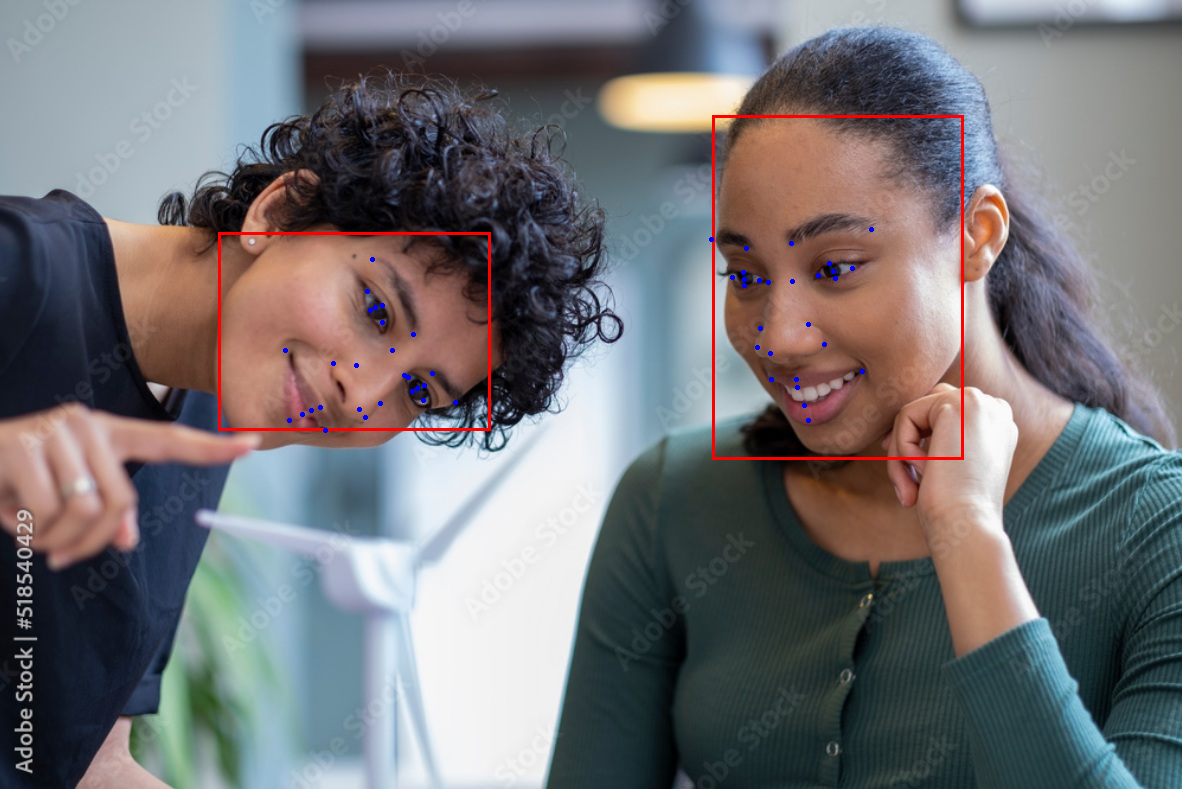

In [26]:
from PIL import Image, ImageDraw

image = Image.open(sample_file_path)
draw = ImageDraw.Draw(image)

for idx, face in enumerate(result):
    # Draw bounding box
    rect = face.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    draw.rectangle([left, top, right, bottom], outline="red", width=3)
    
    # Draw landmarks
    for landmark in face.face_landmarks.as_dict().values():
        x, y = landmark['x'], landmark['y']
        draw.ellipse((x-2, y-2, x+2, y+2), fill="blue")

# Save or display the image with bounding boxes and landmarks
#output_path = "../Data/images/group/group_1_with_boxes_and_landmarks.jpg"
#image.save(output_path)
image.show()

## Create Large Person Group

In [27]:
# Used in the Large Person Group Operations and Delete Large Person Group examples.
# LARGE_PERSON_GROUP_ID should be all lowercase and alphanumeric. For example, 'mygroupname' (dashes are OK).
LARGE_PERSON_GROUP_ID = str(uuid.uuid4())  # assign a random ID (or name it anything)

# Create a Large Person Group
print("Person group:", LARGE_PERSON_GROUP_ID)
face_admin_client.large_person_group.create(
    large_person_group_id=LARGE_PERSON_GROUP_ID,
    name=LARGE_PERSON_GROUP_ID,
    recognition_model=FaceRecognitionModel.RECOGNITION04,
)

Person group: 1ce7137a-7fcc-4952-b262-dbea943573b7


## Add Persons to Groups

In [28]:
# Define person
person_A = face_admin_client.large_person_group.create_person(
    large_person_group_id=LARGE_PERSON_GROUP_ID,
    name="Person A",
)

# Images
person_A_image_file_path = [
    "../Data/images/person_a/person_a1.jpg",
    "../Data/images/person_a/person_a2.jpg",
]

for image in person_A_image_file_path:
    # Read the image file
    file_content = read_file_content(image)

    # Check if the image is of sufficient quality for recognition.
    result = face_client.detect(
        file_content,
        detection_model=FaceDetectionModel.DETECTION03,  # The latest detection model.
        recognition_model=FaceRecognitionModel.RECOGNITION04,  # The latest recognition model.
        return_face_id=True,
        return_face_attributes=[FaceAttributeTypeRecognition04.QUALITY_FOR_RECOGNITION]
    )

    # Ensure only one face is detected and it has high quality for recognition
    if len(result) == 1 and result[0].face_attributes.quality_for_recognition == QualityForRecognition.HIGH:
        face_admin_client.large_person_group.add_face(
            LARGE_PERSON_GROUP_ID,
            person_A.person_id,
            file_content,
            detection_model=FaceDetectionModel.DETECTION03,        
    )
        
    print(f"Face {result[0].face_id} added to person {person_A.person_id}")

Face 7ce73901-5cc3-4078-8510-0ca30d63936b added to person 46e19788-9df4-4dc5-bfc9-5a065c29bc0b
Face 9b934931-3dfb-4d18-a111-9b6a5ecccc17 added to person 46e19788-9df4-4dc5-bfc9-5a065c29bc0b


In [29]:
# Define woman friend
person_B = face_admin_client.large_person_group.create_person(
    large_person_group_id=LARGE_PERSON_GROUP_ID,
    name="Person B",
)

# Images
person_B_image_file_path = [
    "../Data/images/person_b/person_b1.jpg",
    "../Data/images/person_b/person_b2.jpg",
]

for image in person_B_image_file_path:
    # Read the image file
    file_content = read_file_content(image)

    # Check if the image is of sufficient quality for recognition.
    result = face_client.detect(
        file_content,
        detection_model=FaceDetectionModel.DETECTION03,  # The latest detection model.
        recognition_model=FaceRecognitionModel.RECOGNITION04,  # The latest recognition model.
        return_face_id=True,
        return_face_attributes=[FaceAttributeTypeRecognition04.QUALITY_FOR_RECOGNITION]
    )

    # Ensure only one face is detected and it has high quality for recognition
    if len(result) == 1 and result[0].face_attributes.quality_for_recognition == QualityForRecognition.HIGH:
        face_admin_client.large_person_group.add_face(
            LARGE_PERSON_GROUP_ID,
            person_B.person_id,
            file_content,
            detection_model=FaceDetectionModel.DETECTION03,        
    )
        
    print(f"Face {result[0].face_id} added to person {person_B.person_id}")

Face 7eab7c73-2d82-4faa-8b84-0366454a0e56 added to person 3810795a-f9a6-44fa-bf69-1c0b33fe33ad
Face 250afecb-ffe7-4fe9-b822-050bf7882815 added to person 3810795a-f9a6-44fa-bf69-1c0b33fe33ad


## Train the Large Person Group

In [30]:
# Train the large person group and set the polling interval to 5s
print(f"Train the person group {LARGE_PERSON_GROUP_ID}")
poller = face_admin_client.large_person_group.begin_train(
    large_person_group_id=LARGE_PERSON_GROUP_ID,
    polling_interval=5,
)

poller.wait()
print(f"The person group {LARGE_PERSON_GROUP_ID} is trained successfully.")

Train the person group 1ce7137a-7fcc-4952-b262-dbea943573b7
The person group 1ce7137a-7fcc-4952-b262-dbea943573b7 is trained successfully.


## Identify Faces in Images

In [31]:
# Group image for testing against
image="../Data/images/group/group_2.jpg"
file_content = read_file_content(image)


# Detect faces
face_ids = []
# We use detection model 03 to get better performance, recognition model 04 to support quality for recognition attribute.
# Check if the image is of sufficient quality for recognition.
faces = face_client.detect(
    file_content,
    detection_model=FaceDetectionModel.DETECTION03,  # The latest detection model.
    recognition_model=FaceRecognitionModel.RECOGNITION04,  # The latest recognition model.
    return_face_id=True,
    return_face_attributes=[FaceAttributeTypeRecognition04.QUALITY_FOR_RECOGNITION]
)

for face in faces:
    # Only take the face if it is of sufficient quality.
    if face.face_attributes.quality_for_recognition != QualityForRecognition.LOW:
        face_ids.append(face.face_id)

# Identify faces
identify_results = face_client.identify_from_large_person_group(
    face_ids=face_ids,
    large_person_group_id=LARGE_PERSON_GROUP_ID,
)
print("Identifying faces in image")
for identify_result in identify_results:
    if identify_result.candidates:
        print(f"Person is identified for face ID {identify_result.face_id} in image, with a confidence of "
              f"{identify_result.candidates[0].confidence}.")  # Get topmost confidence score

    # Verify faces
        verify_result = face_client.verify_from_large_person_group(
            face_id=identify_result.face_id,
            large_person_group_id=LARGE_PERSON_GROUP_ID,
            person_id=identify_result.candidates[0].person_id,
        )
        print(f"Person Identified: {identify_result.candidates[0].person_id}. Verification result: {verify_result.is_identical}. confidence: {verify_result.confidence}")
    else:
        print(f"No person identified for face ID {identify_result.face_id} in image.")


Identifying faces in image
Person is identified for face ID bb2a2a34-b23b-4df3-85d5-9363e3371dd0 in image, with a confidence of 0.97358.
Person Identified: 46e19788-9df4-4dc5-bfc9-5a065c29bc0b. Verification result: True. confidence: 0.97358
Person is identified for face ID ef7599a0-6da2-4da7-b014-73feeaba4192 in image, with a confidence of 0.94006.
Person Identified: 3810795a-f9a6-44fa-bf69-1c0b33fe33ad. Verification result: True. confidence: 0.94006


## Clean up resources

In [32]:
# Delete the large person group
face_admin_client.large_person_group.delete(LARGE_PERSON_GROUP_ID)
print(f"The person group {LARGE_PERSON_GROUP_ID} is deleted.")

The person group 1ce7137a-7fcc-4952-b262-dbea943573b7 is deleted.
